## Imports

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import random
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, LeakyReLU, Conv2D, MaxPooling2D, Dropout, UpSampling2D
from keras.datasets import mnist
import matplotlib.pyplot as plt
import glob as glob
import cv2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
num_classes = 5
margin = 0.7
EPOCHS = 50
input_shape = (250, 250, 3)
LR = 0.0001
tr_batch_size = 16
te_batch_size = 100

In [6]:
# Load dataset here
# umair 2000 drive
# root_path = "/content/drive/MyDrive/Colab Notebooks/DL/Project/Dataset/"

# ahmad drive
# root_path = "/content/drive/MyDrive/DL Project/Project/Dataset/"

# umi drive
# root_path = "/content/drive/MyDrive/Project/Dataset/"

# umair local
root_path = "Dataset/"

train_paths = [root_path + "Training and Validation/fire/*",
               root_path + "Training and Validation/like fire/*", 
               root_path + "Training and Validation/like smoke/*", 
               root_path + "Training and Validation/nofire/*",
               root_path + "Training and Validation/smoke/*"]

test_paths = [root_path + "Testing/fire/*", 
              root_path + "Testing/like fire/*", 
              root_path + "Testing/like smoke/*", 
              root_path + "Testing/nofire/*",
              root_path + "Testing/smoke/*"]

In [7]:
def load_dataset(dataset_paths):
    images = []
    labels = []
    count = 0

    for path in dataset_paths:
        temp_list = []
        init_len = len(temp_list)

        for filename in glob.glob(path):
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            temp_list.append(img)

        final_len = len(temp_list)
        instances = final_len - init_len
        temp_list = np.array(temp_list)
        images.append(temp_list)
        labels.append([count for i in range(instances)])

        count += 1

    return np.concatenate(images), np.concatenate(labels), images

In [8]:
x_train, y_train, train_set = load_dataset(train_paths)

In [9]:
x_test, y_test, test_set = load_dataset(test_paths)

In [10]:
y_train.shape

(272,)

In [11]:
y_test.shape

(945,)

In [12]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
x_train /= 255
x_test /= 255

In [13]:
def dataloader(x_train, y_train, x_test, y_test):
  train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
  test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
  return train_loader, test_loader

In [14]:
train_loader, test_loader = dataloader(x_train, y_train, x_test, y_test)

In [15]:
image_shape = ()
def preprocess(filename):
    string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_shape)
    return image

## Make triplets for model input

In [16]:
def make_triplets(x, y, num_classes):
    findNorP = [np.where(y == i)[0] for i in range(num_classes)]
   
    triplets_1 = []
    triplets_2 = []
    triplets_3 = []
    
    for index in range(len(x)):
        val1 = x[index]
        A = y[index]
        index2 = random.choice(findNorP[A])
        val2 = x[index2]
        
        N = random.randint(0, num_classes - 1)
        while N == A:
            N = random.randint(0, num_classes - 1)
            
        index2 = random.choice(findNorP[N])
        val3 = x[index2]
        
        triplets_1 += [[val1]]
        triplets_2 += [[val2]]
        triplets_3 += [[val3]]

    triplets_1 = tf.data.Dataset.from_tensor_slices(triplets_1)
    triplets_2 = tf.data.Dataset.from_tensor_slices(triplets_2)
    triplets_3 = tf.data.Dataset.from_tensor_slices(triplets_3)

    return tf.data.Dataset.zip((triplets_1, triplets_2, triplets_3))

In [17]:
triplets_train = make_triplets(x_train, y_train, num_classes)

In [18]:
def triplet_distance(vects):
    anchor, positive, negative = vects
    ap = tf.reduce_sum(tf.square(anchor - positive), -1)
    an = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap, an)

input = Input(input_shape)
x = input

x = Conv2D(filters=128, kernel_size=5, strides=(2, 2))(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=3, strides=(2, 2))(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1))(x)

x = Conv2D(filters=32, kernel_size=3, strides=(1, 1))(x)
x = LeakyReLU()(x)

x = UpSampling2D(size=(3,3), data_format="channels_last")(x)
x = UpSampling2D(size=(2,2), data_format="channels_last")(x)

x = Dense(128)(x)
x = Flatten()(x)
x = LeakyReLU()(x)

middleModel = Model(inputs=input, outputs=x)

ainput = Input(input_shape)
pinput = Input(input_shape)
ninput = Input(input_shape)

merge_layer = Lambda(triplet_distance)([middleModel(ainput), middleModel(pinput), middleModel(ninput)])
model = Model(inputs=[ainput, pinput, ninput], outputs=merge_layer)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR), metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                          

In [20]:
class SiameseModel(Model):
    def __init__(self, distance_net):
       super(SiameseModel, self).__init__()
       self.net = distance_net
       self.loss_tracker = tf.keras.metrics.Mean()
  
    def call(self, inputs):
        return self.net(inputs)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            temp = self.compute_loss(data)
        gradients = tape.gradient(temp, self.net.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.net.trainable_weights))
        self.loss_tracker.update_state(temp)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        temp = self.compute_loss(data)
        self.loss_tracker.update_state(temp)
        return {"loss": self.loss_tracker.result()}
    
    def compute_loss(self, data):
        ap, an = self.net(data)
        loss = ap - an
        loss = tf.maximum(loss + margin, 0.0)
        return loss
    
    @property
    def metrics(self):
        return [self.loss_tracker]

## Training

In [21]:
# finalModel = SiameseModel(model)
# finalModel.compile(optimizer=tf.keras.optimizers.Adam(LR))

In [22]:
# finalModel.load_weights("new_weights.h5")

In [23]:
# finalModel.fit(triplets_train, epochs=EPOCHS)

In [24]:
# middleModel.save_weights("middle_model.h5")
# finalModel.save_weights("final_model.h5")

## TESTING

In [25]:
#umair2000
# middleModel.load_weights("/content/drive/MyDrive/Colab Notebooks/DL/Project/weights.h5")

#ahmad
# middleModel.load_weights("/content/drive/MyDrive/DL Project/Project/weights.h5")

# umair local
middleModel.load_weights("weights.h5")

In [26]:
middleModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 123, 123, 128)     9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 123, 123, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        73792     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 30, 64)        0         
                                                             

In [27]:
classes = ["fire", "fire-like", "smoke-like", "nofire", "smoke"]

def generate_fingerprints():
    fingerprints = []
    # min_val = train_set[0].shape[0]

    # for i in train_set:
    #     if i.shape[0] < min_val:
    #         min_val = i.shape[0]

    for i in train_set:
        loader = tf.data.Dataset.from_tensor_slices((i, [0 for _ in range(len(i))]))
        final_representation = []

        for x_batch, _ in loader.batch(te_batch_size):
            x_batch = x_batch.numpy()
            x = x_batch.astype('float16')
            x = x / 255
            print_val = middleModel.predict(x)
            print_val = np.mean(print_val, axis=0)
            final_representation.append(print_val)

        final_representation = np.array(final_representation)
        final_representation = np.mean(final_representation, axis=0)
        
        fingerprints.append(print_val)

    return fingerprints

fp = generate_fingerprints()
fp[0].shape

2/2 [==============================] - 0s 150ms/step


(3115008,)

In [28]:
def test(testing_data, fingerprints):
  final_preds = []

  for x_batch, y_label in testing_data.batch(te_batch_size):
    latent_space = middleModel.predict(x_batch)
    
    temp_preds = []
    for fp in fingerprints:
      temp = fp - latent_space
      temp = np.linalg.norm(temp, axis=1)
      temp_preds.append(temp)

    results = np.vstack(temp_preds)
    results = np.argmin(results, axis=0)
    final_preds.append(results)

  return np.concatenate(final_preds)

In [29]:
preds = test(test_loader, fp)

2/2 [==============================] - 0s 185ms/step


In [30]:
preds.shape

(945,)

In [31]:
def accuracy(preds, y_true):
    return np.sum(preds == y_true) / len(y_true)

In [32]:
acc = accuracy(preds, y_test)
f1 = metrics.f1_score(y_test, preds, average="macro")

print(f"Accuracy: {(acc * 100):.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 54.29
F1 Score: 0.47


In [43]:
def show_individual_results(i):
  print("actual label:     ", classes[y_test[i]])
  print("predicted label:  ", classes[preds[i]])
  temp = x_test[i].copy()
  temp *= 255
  temp = temp.astype(np.int32)
  plt.imshow(temp)
  plt.show()

actual label:      fire
predicted label:   nofire


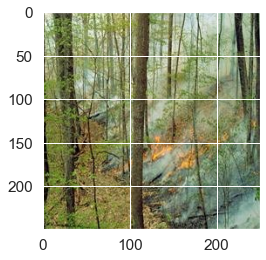

In [44]:
show_individual_results(0)

actual label:      fire-like
predicted label:   fire


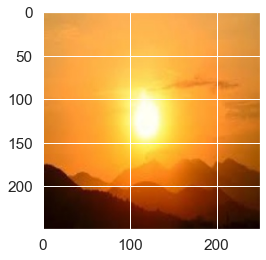

In [55]:
show_individual_results(320)

actual label:      fire-like
predicted label:   fire


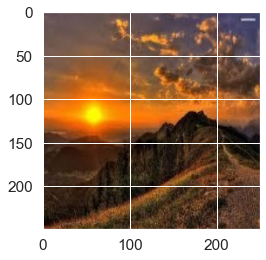

In [57]:
show_individual_results(460)

actual label:      nofire
predicted label:   nofire


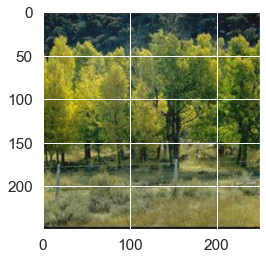

In [47]:
show_individual_results(620)

actual label:      smoke
predicted label:   smoke-like


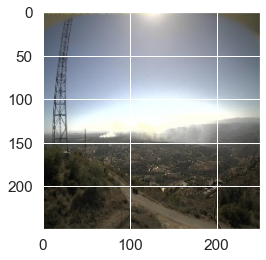

In [48]:
show_individual_results(900)

In [49]:
import pandas as pd
import seaborn as sns
def plot_confusion_matrix(conf_mat):
    df_cm = pd.DataFrame(conf_mat, classes, classes)
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

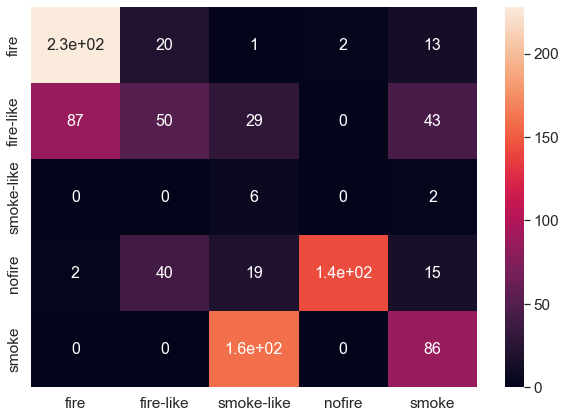

In [51]:
conf_mat = confusion_matrix(y_test, preds)
plot_confusion_matrix(conf_mat)

In [65]:
print(f"Accuracy: {(acc * 100):.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 54.29
F1 Score: 0.47


In [66]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       264
           1       0.45      0.24      0.31       209
           2       0.03      0.75      0.05         8
           3       0.99      0.65      0.79       219
           4       0.54      0.35      0.43       245

    accuracy                           0.54       945
   macro avg       0.55      0.57      0.47       945
weighted avg       0.67      0.54      0.58       945

